In [1]:
from project import Projection
from Problem import Problem
from Phase1 import solve_CQ_feasible
from Phase2_1_obj import optim_Universal
from Phase2_dynamic import optim_Scalarization
from main_dynamic import load_config
from utils import visualize_pareto_front, generate_pareto_grid

In [2]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import pandas as pd
import math
import itertools


In [3]:
case = "_Ex_7_1"

# Prob

In [94]:
import numpy as np
from scipy.optimize import minimize

# ==========================================
# 1. CẤU HÌNH BÀI TOÁN
# ==========================================

# --- Hàm ánh xạ F(x) ---
def f(x):
    return np.array([
        x[0],           # f1
        (x[0] - 1)**2   # f2
    ])

# --- Jacobian của F(x) ---
# Trả về ma trận đạo hàm riêng
def jacobian_f(x):
    # J = [ [df1/dx], [df2/dx] ]
    return np.array([
        [1.0],              # Đạo hàm của x[0]
        [2.0 * (x[0] - 1)]  # Đạo hàm của (x[0]-1)^2
    ])

# --- Hàm mục tiêu Weighted Chebyshev (theo ảnh) ---
def S_weighted_chebyshev(x, r, z):
    vals = f(x)
    # Công thức: max( r_i * |f_i(x) - z_i| )
    weighted_diffs = r * np.abs(vals - z)
    return np.max(weighted_diffs)

# --- Tính Subgradient ---
def get_subgradient(x, r, z):
    """
    Tính đạo hàm của hàm max(r_i * |f_i - z_i|)
    """
    vals = f(x)
    diffs = vals - z
    weighted_abs_diffs = r * np.abs(diffs)
    
    # 1. Tìm chỉ số k làm hàm max đạt giá trị lớn nhất
    k = np.argmax(weighted_abs_diffs)
    
    # 2. Lấy đạo hàm của thành phần thứ k
    # Gradient = r_k * sign(diff_k) * Gradient_fk(x)
    
    J = jacobian_f(x)
    gradient_fk = J[k] # Hàng thứ k của Jacobian
    
    sign = 1.0 if diffs[k] >= 0 else -1.0
    
    grad = r[k] * sign * gradient_fk
    return grad

# ==========================================
# 2. CÁC RÀNG BUỘC & PHÉP CHIẾU (GIỮ NGUYÊN)
# ==========================================
# Ràng buộc tập X
def c1(x): return x[0]
def c2(x): return -x[0] + 1
# Ràng buộc tập Q
def q1(y): return 0.2**2 - (y[0] - 0.4)**2 - (y[1] - 0.4)**2

dim_x = 1
dim_y = 2

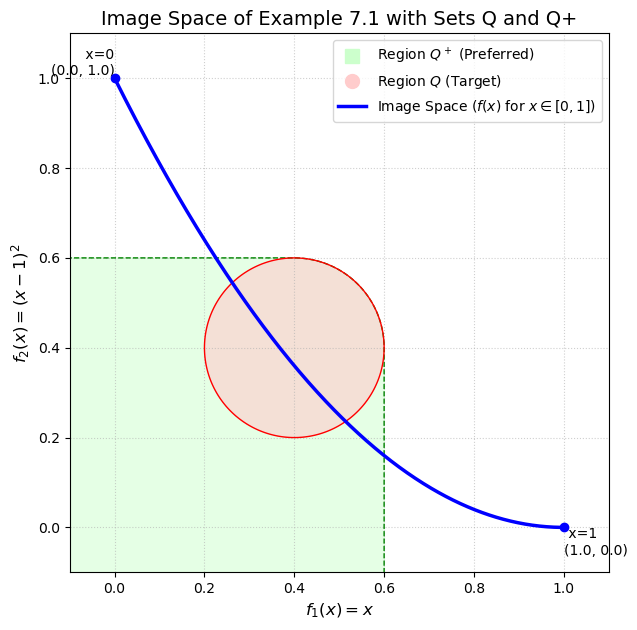

In [35]:
pf_cloud, pf_targets = generate_pareto_grid(
    f_func=f, 
    c_funcs=[c1, c2], 
    q_plus_func=q_plus, 
    resolution=500
)

--- Đang quét lưới 500x500 điểm ---
-> Tìm thấy 250000 điểm thỏa mãn miền C.
-> Lọc còn 93500 điểm thỏa mãn Q+ (Cloud).
-> Kết quả: 187 điểm Pareto.


In [95]:
def project_step(x_temp, y_temp, dim_x, dim_y):
    """
    Chiếu (x, y) lên tập khả thi {x in X, y in Q, F(x) <= y}
    """
    z_start = np.concatenate([x_temp, y_temp])
    
    # Mục tiêu projection: gần điểm cũ nhất có thể
    def proj_obj(z): return 0.5 * np.sum((z - z_start)**2)
    def proj_jac(z): return z - z_start

    # Các ràng buộc cho scipy minimize
    constraints = [
        {'type': 'ineq', 'fun': lambda z: c1(z[:dim_x])},       # x trong X
        {'type': 'ineq', 'fun': lambda z: c2(z[:dim_x])},       # x trong X
        {'type': 'ineq', 'fun': lambda z: q1(z[dim_x:])},       # y trong Q
        {'type': 'ineq', 'fun': lambda z: z[dim_x:] - f(z[:dim_x])} # F(x) <= y
    ]

    res = minimize(
        fun=proj_obj, x0=z_start, jac=proj_jac,
        constraints=constraints, method='SLSQP',
        options={'disp': False}
    )
    
    if not res.success: return x_temp, y_temp
    return res.x[:dim_x], res.x[dim_x:]

# ==========================================
# 3. THUẬT TOÁN PROJECTED SUBGRADIENT DESCENT
# ==========================================

def solve_weighted_chebyshev(r_pref, z_ref, dim_x=1, dim_y=2, learning_rate=0.01, max_iters=5000, tol=1e-5):
    
    # Khởi tạo điểm bắt đầu
    x = np.array([0.8])      
    y = np.array([0.8, 1.8]) 
    
    # Biến lưu giá trị hàm mục tiêu của bước trước (Khởi tạo là vô cùng)
    prev_obj_val = float('inf')
    
    print(f"Bắt đầu giải với r={r_pref}, z*={z_ref}")
    print(f"{'Iter':<5} | {'x':<10} | {'y vector':<15} | {'Objective':<10} | {'Active Idx'}")
    print("-" * 75)

    for k in range(max_iters):
        # --- BƯỚC 1: Tính Subgradient ---
        grad_x = get_subgradient(x, r_pref, z_ref)
        
        # --- BƯỚC 2: Cập nhật biến x ---
        x_temp = x - learning_rate * grad_x
        y_temp = y 
        
        # --- BƯỚC 3: Phép chiếu (Projection) ---
        x_next, y_next = project_step(x_temp, y_temp, dim_x, dim_y)
        
        # --- Tính giá trị hàm mục tiêu hiện tại ---
        obj_val = S_weighted_chebyshev(x_next, r_pref, z_ref)
        
        # --- Logging ---
        diffs = r_pref * np.abs(f(x_next) - z_ref)
        active_idx = np.argmax(diffs)
        
        if k % 2000 == 0: # In thường xuyên hơn một chút để dễ quan sát
            print(f"{k:<5} | {x_next[0]:.4f}     | [{y_next[0]:.2f}, {y_next[1]:.2f}] | {obj_val:.6f}     | f_{active_idx+1}")

        # --- BƯỚC 4: Kiểm tra điều kiện dừng (MỚI) ---
        # So sánh độ sụt giảm của hàm mục tiêu
        loss_change = abs(prev_obj_val - obj_val)
        
        if loss_change < tol:
            print(f"\n--> Hội tụ theo hàm mục tiêu tại bước {k}!")
            print(f"    Chênh lệch mục tiêu: {loss_change:.8f} < {tol}")
            print(f"    Giá trị cuối cùng  : {obj_val:.6f}")
            break
            
        # Cập nhật giá trị cũ cho vòng lặp sau
        prev_obj_val = obj_val
        x = x_next
        y = y_next

    return x, y

In [96]:
base_cfg = load_config()
test_rays = base_cfg['data']['test_ray']

In [88]:
pareto_f_temp = []
z_star = np.array([0.2, 0.1]) 
learning_rate = 0.003
max_iters = 10000
for r in test_rays:
    x, y = solve_weighted_chebyshev(r_pref=r, z_ref=z_star, dim_x=dim_x, dim_y=dim_y, learning_rate=learning_rate, max_iters=max_iters)
    pareto_f_temp.append(f(x))

Bắt đầu giải với r=[1. 0.], z*=[0.2 0.1]
Iter  | x          | y vector        | Objective  | Active Idx
---------------------------------------------------------------------------
0     | 0.4901     | [0.49, 0.58] | 0.290142     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 261!
    Chênh lệch mục tiêu: 0.00000993 < 1e-05
    Giá trị cuối cùng  : 0.025916
Bắt đầu giải với r=[0.99658449 0.08257935], z*=[0.2 0.1]
Iter  | x          | y vector        | Objective  | Active Idx
---------------------------------------------------------------------------
0     | 0.4901     | [0.49, 0.58] | 0.289152     | f_1

--> Hội tụ theo hàm mục tiêu tại bước 92!
    Chênh lệch mục tiêu: 0.00000215 < 1e-05
    Giá trị cuối cùng  : 0.039591
Bắt đầu giải với r=[0.9863613  0.16459459], z*=[0.2 0.1]
Iter  | x          | y vector        | Objective  | Active Idx
---------------------------------------------------------------------------
0     | 0.4901     | [0.49, 0.58] | 0.286188     | f_1

--> Hội tụ theo hàm

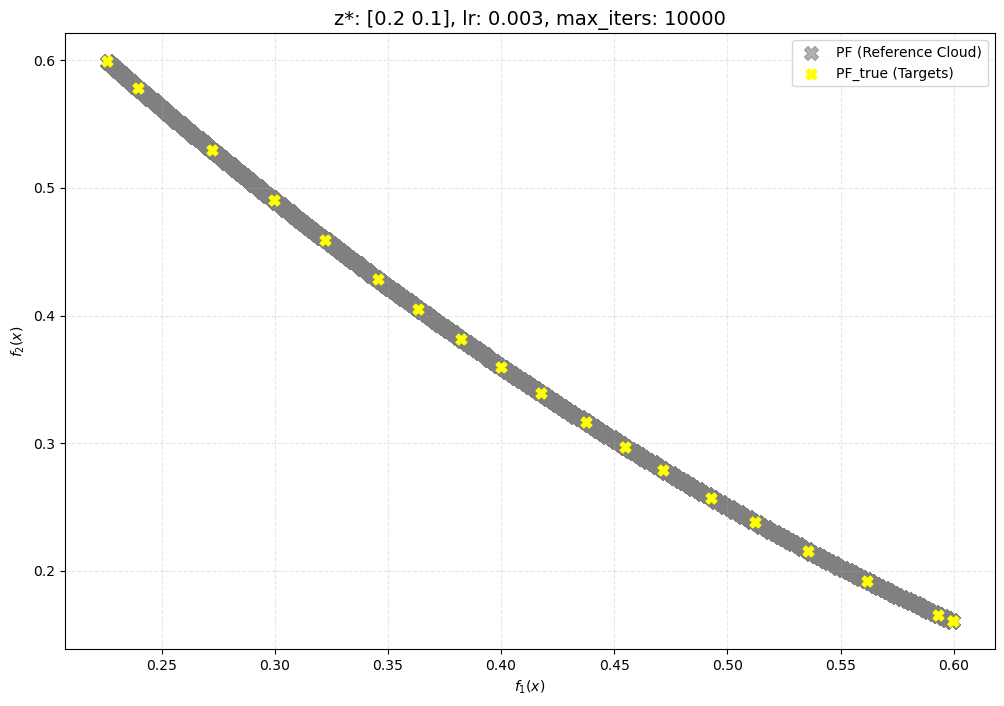

In [86]:
visualize_pareto_front(
    pf_targets=np.array(pareto_f_temp), 
    pf_cloud=pf_cloud,   
#     pf_targets=results["pareto_f"],
    title=f"z*: {z_star}, lr: {learning_rate}, max_iters: {max_iters}",
    figsize=(12, 8)
)

In [92]:
np.save(f"test/{case}/pf_true.npy", np.array(pareto_f_temp))